In [1]:
pip install ffmpeg-python pillow
pip install imageio[ffmpeg] pillow
pip install plotly

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# if the files are in avi

In [9]:
import imageio
from PIL import Image
import os

output_dir = "E:\heart_beat\F1_T3"
os.makedirs(output_dir, exist_ok=True)

# Path to the input AVI file
input_file = r'E:\heart_beat\F1_T3.avi'

reader = imageio.get_reader(input_file, 'ffmpeg')

# Extract and save frames as TIFF
frame_count = 0
for frame in reader:
    # Convert frame (numpy array) to a PIL Image
    img = Image.fromarray(frame)
    
    # Save the frame as a TIFF file
    tiff_path = os.path.join(output_dir, f'output_{frame_count:04d}.tiff')
    img.save(tiff_path)
    
    frame_count += 1

print(f"Converted {frame_count} frames to TIFF format.")


Converted 6300 frames to TIFF format.


# if data is in tiff

In [27]:
import pandas as pd
import plotly.graph_objects as go

# Function to load CSV files
def load_csv(file_path):
    return pd.read_csv(file_path)

# Load the CSV files
bg_file_path = r'E:\heart_beat\Maha\f3t4_bg.csv'
heart_file_path = r'E:\heart_beat\Maha\f3t4_heart.csv'
#jaw_file_path =r'E:\heart_beat\jaw_F2_T3.csv'
bg_df = load_csv(bg_file_path)
heart_df = load_csv(heart_file_path)
#jaw_df=load_csv(jaw_file_path)
# Ensure that the dataframes are aligned by the same index or time column
# Assuming both files have a 'time' column and the same time points
# If they have different columns, adjust accordingly


bg_df.set_index('Slice', inplace=True)
heart_df.set_index('Slice', inplace=True)
#jaw_df.set_index('Slice', inplace=True)

# Subtract background from heart
result_df = heart_df - bg_df
#result_df = result_df1 - jaw_df

#csv_path = r"E:\heart_beat\F2_T3.csv"
#result_df.to_csv(csv_path, index=False)

# Create an interactive plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=result_df.index, y=result_df.values.flatten(), mode='lines', name='Heart - Background'))

# Update layout for better interactivity
fig.update_layout(
    title='F3_T2 Time Series: Heart - Background',
    xaxis_title='Time',
    yaxis_title='Value',
    xaxis_rangeslider_visible=True
)

# Show the plot
fig.show()

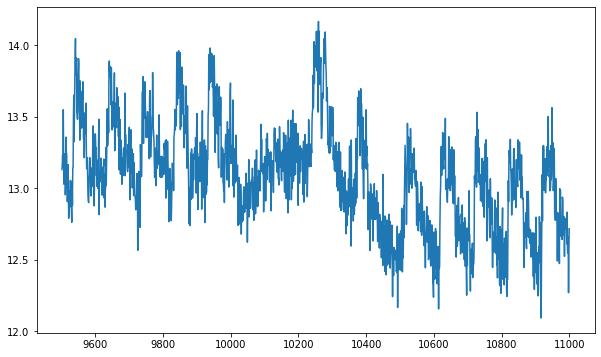

In [21]:
import matplotlib.pyplot as plt

# Assuming result_df1 and jaw_df are defined earlier in the script


# Define the window for plotting (e.g., from index 100 to 200)
start_index = 9500
end_index = 11000

# Subset the DataFrame to the desired window
window_df = result_df[start_index:end_index]

# Create a static plot
plt.figure(figsize=(10, 6))
plt.plot(window_df.index, window_df.values.flatten(), label='Heart - Background')
#plt.title('Heart - Background Signal within Specific Window')
#plt.xlabel('Index')
#plt.ylabel('Signal Value')
#plt.legend()
plt.grid(False)

plt.savefig('heart.svg')
# Display the plot
plt.show()


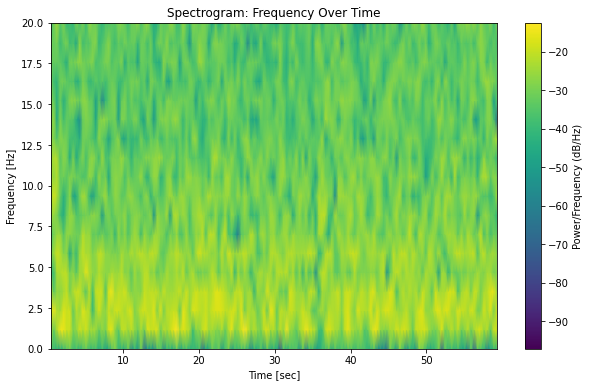

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import spectrogram

# Function to load CSV files
def load_csv(file_path):
    return pd.read_csv(file_path)

# Load the CSV files
bg_file_path = r'E:\heart_beat\Maha\f6t3_bg.csv'
heart_file_path = r'E:\heart_beat\Maha\f6t3_heart.csv'

bg_df = load_csv(bg_file_path)
heart_df = load_csv(heart_file_path)

# Set the index to 'Slice'
bg_df.set_index('Slice', inplace=True)
heart_df.set_index('Slice', inplace=True)

# Subtract background from heart
result_df = heart_df - bg_df

# Perform Short-Time Fourier Transform (STFT)
signal = result_df.values.flatten()
sampling_rate = 300  # 30 frames per second

# Compute the spectrogram
frequencies, times, Sxx = spectrogram(signal, fs=sampling_rate, nperseg=256, noverlap=128)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.title('Spectrogram: Frequency Over Time')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0,20)
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.show()


In [64]:
import pandas as pd
import pickle
import os



# Extract the identifier from the heart file path (e.g., 'f1t2')
identifier = os.path.basename(heart_file_path).split('_')[0]


# Create DataFrames for saving
frequencies_df = pd.DataFrame(frequencies, columns=['Frequencies'])
times_df = pd.DataFrame(times, columns=['Times'])
Sxx_df = pd.DataFrame(Sxx)

# Specify the output directory
output_dir = r'E:\heart_beat\output'

# Ensure the output directory exists; if not, create it
os.makedirs(output_dir, exist_ok=True)

# Save each component as CSV with dynamically extracted identifier in the filename
frequencies_df.to_csv(os.path.join(output_dir, f'frequencies_{identifier}.csv'), index=False)
times_df.to_csv(os.path.join(output_dir, f'times_{identifier}.csv'), index=False)
Sxx_df.to_csv(os.path.join(output_dir, f'Sxx_{identifier}.csv'), index=False)

# Save the entire spectrogram data as a pickle file
spectrogram_data = {
    
    'frequencies': frequencies,
    'times': times,
    'Sxx': Sxx
}

# Save to pickle with the identifier
with open(os.path.join(output_dir, f'spectrogram_data_{identifier}.pkl'), 'wb') as f:
    pickle.dump(spectrogram_data, f)

print(f"Spectrogram data saved successfully in directory '{output_dir}' with identifier '{identifier}'.")


Spectrogram data saved successfully in directory 'E:\heart_beat\output' with identifier 'f6t3'.


Frequencies over time saved successfully to E:\heart_beat\output\frequencies_over_time_f6t3.csv.


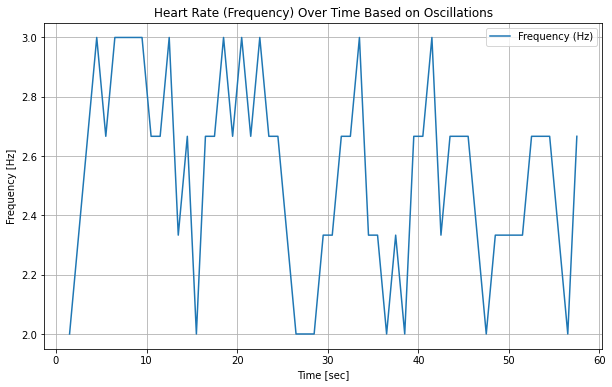

In [65]:
import numpy as np
import scipy.signal as sig  # Use 'sig' to avoid conflict with variable names
import matplotlib.pyplot as plt
import pandas as pd
import os

# Define a bandpass filter to isolate oscillations within a specific frequency range (e.g., 0.5 to 5 Hz)
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = sig.butter(order, [low, high], btype='band')
    y = sig.filtfilt(b, a, data)
    return y

# Function to count zero-crossings (each zero-crossing represents a half oscillation)
def count_zero_crossings(data):
    zero_crossings = np.where(np.diff(np.sign(data)))[0]
    return len(zero_crossings) // 2  # Divide by 2 for full oscillations

# Your pixel intensity time-series after background subtraction (assumed to be in result_df)
signal = result_df.values.flatten()  # Example: result_df contains the pixel intensities over time

# Extract the identifier from the heart file path

identifier = os.path.basename(heart_file_path).split('_')[0]

# Define sampling rate (300 fps)
fs = 300  # frames per second

# Define the bandpass filter range (e.g., 0.5 Hz to 5 Hz for heart rate)
lowcut = 0.5  # Lower frequency bound (in Hz)
highcut = 5   # Upper frequency bound (in Hz)

# 1. Apply a bandpass filter to remove noise and retain relevant frequencies
filtered_signal = bandpass_filter(signal, lowcut, highcut, fs)

# 2. Define the sliding window and step size
window_size = 3 * fs  # 3 seconds worth of frames
step_size = 1 * fs  # Slide the window by 1 second (300 frames)

# Lists to store the results
oscillations_over_time = []
frequencies_over_time = []
time_stamps = []

# 3. Loop over the entire trace in sliding windows
for start in range(0, len(filtered_signal) - window_size, step_size):
    end = start + window_size
    signal_window = filtered_signal[start:end]
    
    # Count zero-crossings in the window to estimate the number of oscillations
    num_oscillations = count_zero_crossings(signal_window)
    
    # Calculate the frequency (oscillations per second)
    window_duration_seconds = window_size / fs  # 3 seconds window duration
    frequency = num_oscillations / window_duration_seconds  # Frequency in Hz
    
    # Store the results
    oscillations_over_time.append(num_oscillations)
    frequencies_over_time.append(frequency)
    time_stamps.append((start + end) / (2 * fs))  # Midpoint of the window, converted to time in seconds

# Create a DataFrame with time points and frequencies
frequency_df = pd.DataFrame({
    'Time': time_stamps,
    'Frequency (Hz)': frequencies_over_time
})

# Specify the output directory
output_dir = r'E:\heart_beat\output'

# Ensure the output directory exists; if not, create it
os.makedirs(output_dir, exist_ok=True)

# Save the DataFrame as a CSV file with the identifier in the filename
csv_filename = os.path.join(output_dir, f'frequencies_over_time_{identifier}.csv')
frequency_df.to_csv(csv_filename, index=False)

print(f"Frequencies over time saved successfully to {csv_filename}.")

# Optional: Plot the frequency over time
plt.figure(figsize=(10, 6))
plt.plot(time_stamps, frequencies_over_time, label='Frequency (Hz)')
plt.title('Heart Rate (Frequency) Over Time Based on Oscillations')
plt.xlabel('Time [sec]')
plt.ylabel('Frequency [Hz]')
plt.grid(True)
plt.legend()
plt.show()


# combining data

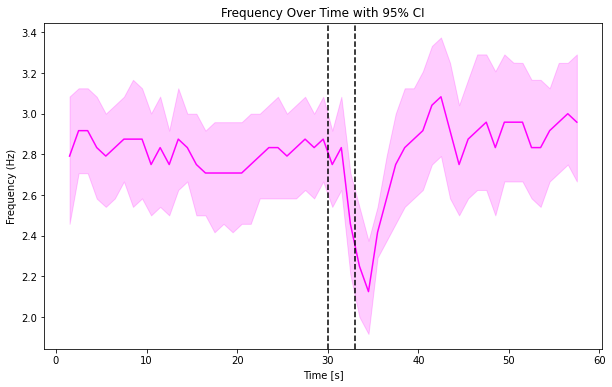

Plot saved as E:\heart_beat\output\frequency_over_time.svg.


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Specify the root directory containing the CSV files
root_dir = r'E:\heart_beat\output\freq'

# Initialize an empty list to store the data from each CSV
data_list = []

# Loop over all files in the root directory
for filename in os.listdir(root_dir):
    if filename.endswith(".csv"):
        # Construct the full file path
        file_path = os.path.join(root_dir, filename)
        
        # Load the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Add a 'File' column to keep track of which file the data came from
        df['File'] = filename
        
        # Append the DataFrame to the list
        data_list.append(df)

# Combine all the DataFrames into a single DataFrame
combined_df = pd.concat(data_list, ignore_index=True)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the data using Seaborn with a 95% confidence interval and magenta line color
sns.lineplot(x='Time', y='Frequency (Hz)', data=combined_df, ci=95, color='magenta')

# Add vertical lines from 30 to 33 seconds
plt.axvline(x=30, color='black', linestyle='--')
plt.axvline(x=33, color='black', linestyle='--')

# Add plot labels and title
plt.title('Frequency Over Time with 95% CI')
plt.xlabel('Time [s]')
plt.ylabel('Frequency (Hz)')

# Remove the grid
plt.grid(False)

# Save the plot as an SVG file
output_svg = r'E:\heart_beat\output\frequency_over_time.svg'
plt.savefig(output_svg, format='svg')

# Show the plot
plt.show()

print(f"Plot saved as {output_svg}.")


Processing file: frequencies_over_time_f1t2.csv
Loaded data with 57 rows and 2 columns.
Baseline frequency (25-30s): 3.00 Hz
Detected minimum frequency after stimulation: 2.00 Hz at 33.50 seconds
Amplitude of the downward peak: 1.00 Hz
Time to peak: 0.50 seconds after stimulation end
Plotting data for frequencies_over_time_f1t2.csv


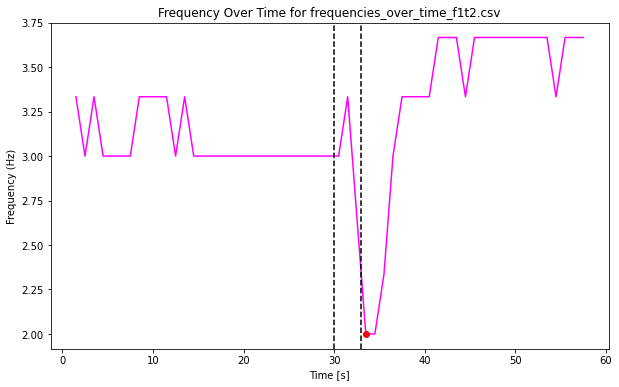

Processing file: frequencies_over_time_f1t3.csv
Loaded data with 57 rows and 2 columns.
Baseline frequency (25-30s): 3.27 Hz
Detected minimum frequency after stimulation: 2.00 Hz at 34.50 seconds
Amplitude of the downward peak: 1.27 Hz
Time to peak: 1.50 seconds after stimulation end
Plotting data for frequencies_over_time_f1t3.csv


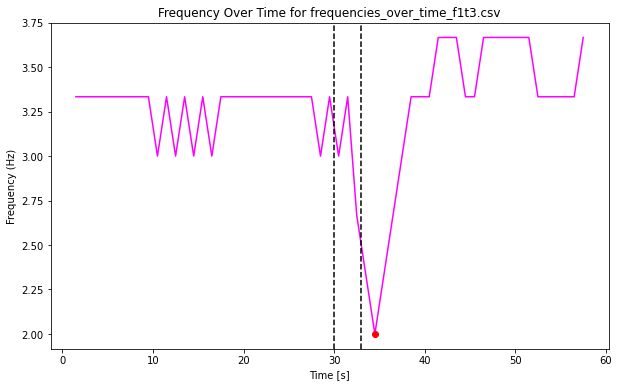

Processing file: frequencies_over_time_f2t4.csv
Loaded data with 57 rows and 2 columns.
Baseline frequency (25-30s): 3.00 Hz
Detected minimum frequency after stimulation: 2.00 Hz at 33.50 seconds
Amplitude of the downward peak: 1.00 Hz
Time to peak: 0.50 seconds after stimulation end
Plotting data for frequencies_over_time_f2t4.csv


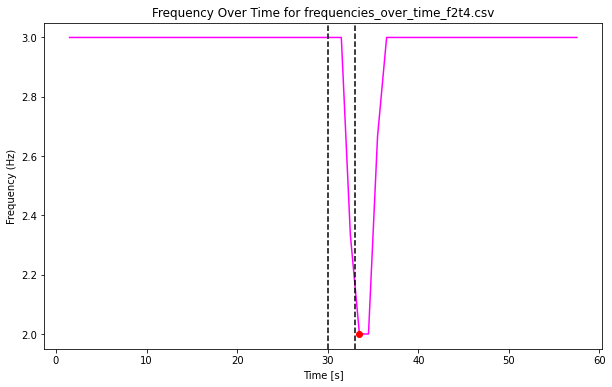

Processing file: frequencies_over_time_f2t5.csv
Loaded data with 57 rows and 2 columns.
Baseline frequency (25-30s): 2.87 Hz
Detected minimum frequency after stimulation: 1.67 Hz at 34.50 seconds
Amplitude of the downward peak: 1.20 Hz
Time to peak: 1.50 seconds after stimulation end
Plotting data for frequencies_over_time_f2t5.csv


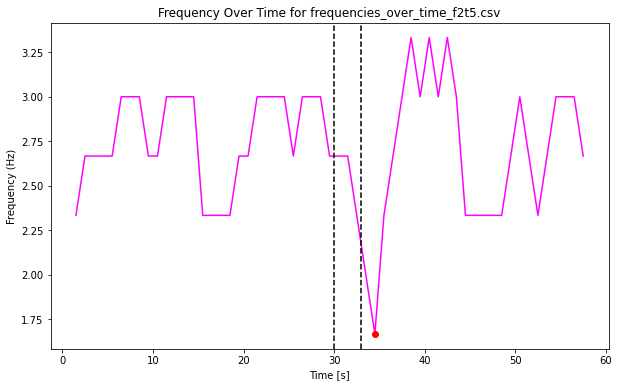

Processing file: frequencies_over_time_f3t2.csv
Loaded data with 57 rows and 2 columns.
Baseline frequency (25-30s): 2.33 Hz
Detected minimum frequency after stimulation: 1.67 Hz at 33.50 seconds
Amplitude of the downward peak: 0.67 Hz
Time to peak: 0.50 seconds after stimulation end
Plotting data for frequencies_over_time_f3t2.csv


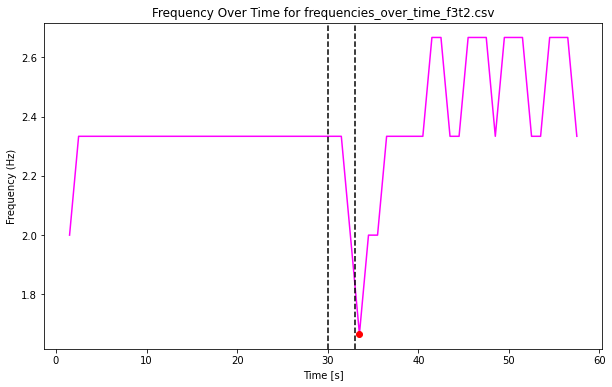

Processing file: frequencies_over_time_f3t4.csv
Loaded data with 57 rows and 2 columns.
Baseline frequency (25-30s): 2.40 Hz
Detected minimum frequency after stimulation: 2.00 Hz at 34.50 seconds
Amplitude of the downward peak: 0.40 Hz
Time to peak: 1.50 seconds after stimulation end
Plotting data for frequencies_over_time_f3t4.csv


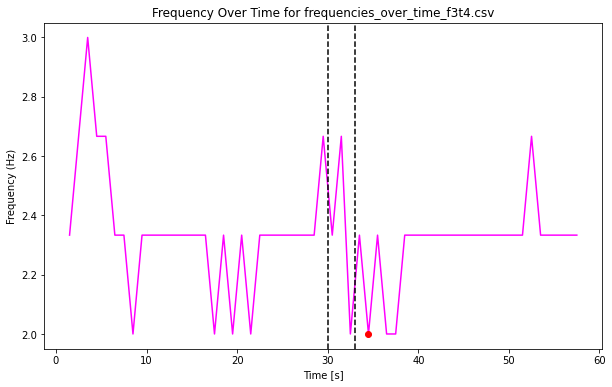

Processing file: frequencies_over_time_f6t1.csv
Loaded data with 57 rows and 2 columns.
Baseline frequency (25-30s): 2.87 Hz
Detected minimum frequency after stimulation: 2.33 Hz at 36.50 seconds
Amplitude of the downward peak: 0.53 Hz
Time to peak: 3.50 seconds after stimulation end
Plotting data for frequencies_over_time_f6t1.csv


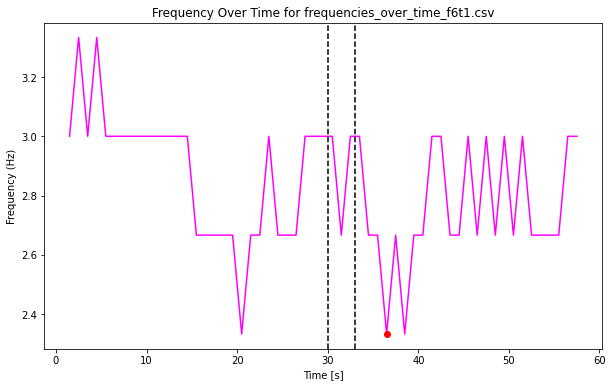

Processing file: frequencies_over_time_f6t2.csv
Loaded data with 57 rows and 2 columns.
Baseline frequency (25-30s): 3.00 Hz
Detected minimum frequency after stimulation: 2.67 Hz at 33.50 seconds
Amplitude of the downward peak: 0.33 Hz
Time to peak: 0.50 seconds after stimulation end
Plotting data for frequencies_over_time_f6t2.csv


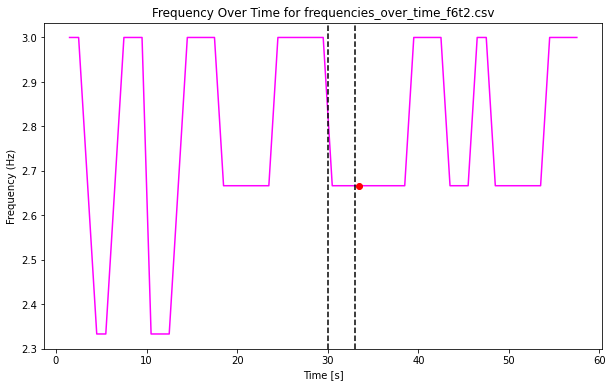

Processing file: mean_frequencies_per_trial.csv
Loaded data with 27 rows and 3 columns.
Error: Required columns 'Time' or 'Frequency (Hz)' not found in mean_frequencies_per_trial.csv


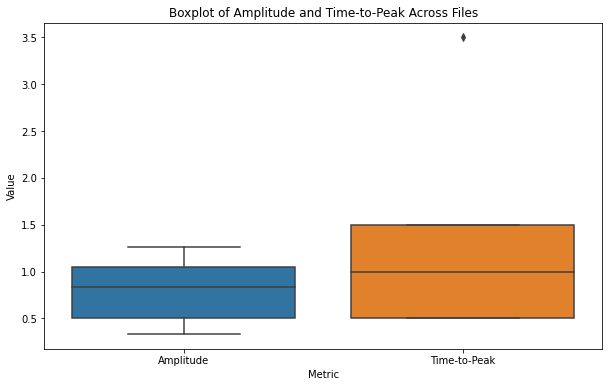

                             File  Amplitude  Time-to-Peak
0  frequencies_over_time_f1t2.csv   1.000000           0.5
1  frequencies_over_time_f1t3.csv   1.266667           1.5
2  frequencies_over_time_f2t4.csv   1.000000           0.5
3  frequencies_over_time_f2t5.csv   1.200000           1.5
4  frequencies_over_time_f3t2.csv   0.666667           0.5
5  frequencies_over_time_f3t4.csv   0.400000           1.5
6  frequencies_over_time_f6t1.csv   0.533333           3.5
7  frequencies_over_time_f6t2.csv   0.333333           0.5


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Specify the root directory containing the CSV files
root_dir = r'C:\Maha\DATA\heart_beat\freq_1\freq'

# Initialize lists to store the peak amplitude and time-to-peak values for each file
amplitudes = []
time_to_peaks = []
file_names = []

# Loop over all files in the root directory
for filename in os.listdir(root_dir):
    if filename.endswith(".csv"):
        print(f"Processing file: {filename}")
        
        # Construct the full file path
        file_path = os.path.join(root_dir, filename)
        
        # Load the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        print(f"Loaded data with {df.shape[0]} rows and {df.shape[1]} columns.")
        
        # Check and print the columns of the DataFrame
        if 'Time' not in df.columns or 'Frequency (Hz)' not in df.columns:
            print(f"Error: Required columns 'Time' or 'Frequency (Hz)' not found in {filename}")
            continue  # Skip this file and move to the next one if the columns are missing
        
        # Baseline: Calculate the mean frequency from 25 to 30 seconds
        baseline = df[(df['Time'] >= 25) & (df['Time'] <= 30)]['Frequency (Hz)'].mean()
        print(f"Baseline frequency (25-30s): {baseline:.2f} Hz")
        
        # Find the time and value of the minimum frequency after stimulation (after 33 seconds)
        post_stim_df = df[df['Time'] > 33]
        min_freq = post_stim_df['Frequency (Hz)'].min()
        min_time = post_stim_df[post_stim_df['Frequency (Hz)'] == min_freq]['Time'].values[0]
        print(f"Detected minimum frequency after stimulation: {min_freq:.2f} Hz at {min_time:.2f} seconds")
        
        # Compute the amplitude as the difference between the baseline and the minimum frequency
        amplitude = baseline - min_freq
        print(f"Amplitude of the downward peak: {amplitude:.2f} Hz")
        
        # Compute the time-to-peak (difference between stimulation onset and time of the peak)
        time_to_peak = min_time - 33
        print(f"Time to peak: {time_to_peak:.2f} seconds after stimulation end")
        
        # Append results to the lists
        amplitudes.append(amplitude)
        time_to_peaks.append(time_to_peak)
        file_names.append(filename)
        
        # Plot the data and mark the detected peak
        print(f"Plotting data for {filename}")
        plt.figure(figsize=(10, 6))
        sns.lineplot(x='Time', y='Frequency (Hz)', data=df, color='magenta')
        
        # Add vertical lines for stimulation start (30s) and end (33s)
        plt.axvline(x=30, color='black', linestyle='--')
        plt.axvline(x=33, color='black', linestyle='--')
        
        # Mark the peak with a red cross
        plt.scatter(min_time, min_freq, color='red', zorder=5)
        
        # Add labels and title
        plt.title(f'Frequency Over Time for {filename}')
        plt.xlabel('Time [s]')
        plt.ylabel('Frequency (Hz)')
        
        # Remove grid
        plt.grid(False)
        
        # Show plot for this file
        plt.show()

# Now, create boxplots for amplitude and time-to-peak across all files

# Create a DataFrame for the results
results_df = pd.DataFrame({
    'File': file_names,
    'Amplitude': amplitudes,
    'Time-to-Peak': time_to_peaks
})

# Create a melted DataFrame for combined boxplot
melted_df = results_df.melt(id_vars='File', var_name='Metric', value_name='Value')

# Plot combined boxplot for Amplitude and Time-to-Peak
plt.figure(figsize=(10, 6))
sns.boxplot(data=melted_df, x='Metric', y='Value')
plt.title('Boxplot of Amplitude and Time-to-Peak Across Files')
plt.ylabel('Value')
plt.show()

# Display the results DataFrame
print(results_df)



Statistics for Amplitude:
  Mean: 0.80
  Median: 0.83
  Standard Deviation (std): 0.36
  Standard Error of the Mean (sem): 0.13

Statistics for Time-to-Peak:
  Mean: 1.25
  Median: 1.00
  Standard Deviation (std): 1.04
  Standard Error of the Mean (sem): 0.37


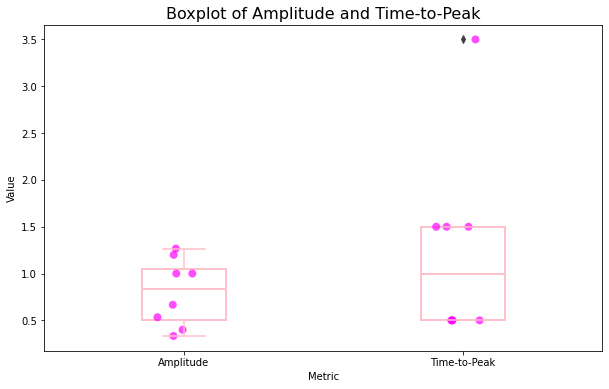

Plot saved as C:\Maha\DATA\heart_beat\freq_1\freq\boxplot_amplitude_time_to_peak.svg.


In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a DataFrame for the results (using your real data)
results_df = pd.DataFrame({
    'File': file_names,       # Make sure you have the file_names, amplitudes, and time_to_peaks lists from earlier.
    'Amplitude': amplitudes,
    'Time-to-Peak': time_to_peaks
})

# Calculate statistics for both Amplitude and Time-to-Peak
for metric in ['Amplitude', 'Time-to-Peak']:
    mean_value = results_df[metric].mean()
    median_value = results_df[metric].median()
    std_value = results_df[metric].std()
    sem_value = results_df[metric].sem()
    
    # Print the results for each metric
    print(f"\nStatistics for {metric}:")
    print(f"  Mean: {mean_value:.2f}")
    print(f"  Median: {median_value:.2f}")
    print(f"  Standard Deviation (std): {std_value:.2f}")
    print(f"  Standard Error of the Mean (sem): {sem_value:.2f}")

# Create a melted DataFrame for combined boxplot
melted_df = results_df.melt(id_vars='File', var_name='Metric', value_name='Value')

# Set up the figure and axis
plt.figure(figsize=(10, 6))

# Plot the boxplot with specified styling
sns.boxplot(
    data=melted_df, x='Metric', y='Value', 
    boxprops={'facecolor':'white', 'edgecolor':'pink', 'linewidth':2},  # White box with pink outline
    medianprops={'color':'pink', 'linewidth':2},                       # Pink median line
    whiskerprops={'color':'pink'},                                     # Pink whiskers
    capprops={'color':'pink'},                                         # Pink caps
    width=0.3                                                          # Reduce box width
)

# Add a strip plot to show the data points
sns.stripplot(
    data=melted_df, x='Metric', y='Value', 
    color='magenta', jitter=True, size=8,                              # Magenta scatter points
    alpha=0.7, zorder=1                                                # Slight transparency for visibility
)

# Add plot title and adjust labels
plt.title('Boxplot of Amplitude and Time-to-Peak', fontsize=16)
plt.ylabel('Value')

# Save the plot as an SVG file
output_svg = r'C:\Maha\DATA\heart_beat\freq_1\freq\boxplot_amplitude_time_to_peak.svg'
plt.savefig(output_svg, format='svg')

# Show the plot
plt.show()

# Confirm that the file was saved
print(f"Plot saved as {output_svg}.")



Data for 'pre' interval:
                             Trial Interval  Mean Frequency
0   frequencies_over_time_f1t2.csv      pre        3.000000
3   frequencies_over_time_f1t3.csv      pre        3.222222
6   frequencies_over_time_f2t4.csv      pre        3.000000
9   frequencies_over_time_f2t5.csv      pre        2.888889
12  frequencies_over_time_f3t2.csv      pre        2.333333
15  frequencies_over_time_f3t4.csv      pre        2.444444
18  frequencies_over_time_f6t1.csv      pre        3.000000
21  frequencies_over_time_f6t2.csv      pre        3.000000

Data for 'stim' interval:
                             Trial Interval  Mean Frequency
1   frequencies_over_time_f1t2.csv     stim        3.000000
4   frequencies_over_time_f1t3.csv     stim        3.000000
7   frequencies_over_time_f2t4.csv     stim        2.777778
10  frequencies_over_time_f2t5.csv     stim        2.555556
13  frequencies_over_time_f3t2.csv     stim        2.222222
16  frequencies_over_time_f3t4.csv     stim    

C:\Users\m.dhanasekar\AppData\Local\Temp\ipykernel_18972\3083865017.py:51: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "p-" (-> marker='p'). The keyword argument will take precedence.

C:\Users\m.dhanasekar\AppData\Local\Temp\ipykernel_18972\3083865017.py:54: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "^-" (-> marker='^'). The keyword argument will take precedence.



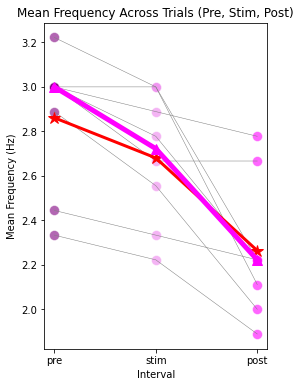

Plot saved as E:\heart_beat\output\frequency_plot.svg


In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

# Assuming mean_df has been generated as in the previous code
# Print debug information to verify data points per interval
for label in ['pre', 'stim', 'post']:
    print(f"\nData for '{label}' interval:")
    print(mean_df[mean_df['Interval'] == label])

# Start plotting
plt.figure(figsize=(4, 6))

# Set colors for the intervals
colors = {
    'pre': 'purple',
    'stim': 'violet',
    'post': 'magenta'
}

# Reduce alpha for transparency
point_alpha = 0.6

# Plot individual points for each trial in the respective colors for each interval
for interval, color in colors.items():
    sns.scatterplot(data=mean_df[mean_df['Interval'] == interval],
                    x='Interval', y='Mean Frequency', color=color, s=100, alpha=point_alpha)

# Draw lines connecting the pre, stim, and post values for each trial
for trial in mean_df['Trial'].unique():
    trial_data = mean_df[mean_df['Trial'] == trial]
    plt.plot(trial_data['Interval'], trial_data['Mean Frequency'], color='gray', linewidth=0.5)

# Calculate the mean and median for each interval across all trials
means = mean_df.groupby('Interval')['Mean Frequency'].mean()
medians = mean_df.groupby('Interval')['Mean Frequency'].median()

# Print the calculated means and medians for each interval (for debugging purposes)
print("\nCalculated Means:")
print(means)

print("\nCalculated Medians:")
print(medians)

# Ensure the correct order for plotting
intervals_order = ['pre', 'stim', 'post']

# Plot the mean as a star with red lines
plt.plot(intervals_order, means[intervals_order], 'p-', color='red', markersize=12, label='Mean', linewidth=3, marker='*')

# Plot the median as a triangle with blue lines, increasing line thickness
plt.plot(intervals_order, medians[intervals_order], '^-', color='magenta', markersize=10, label='Median', linewidth=5, marker='^')

# Add labels and title
plt.title('Mean Frequency Across Trials (Pre, Stim, Post)')
plt.xlabel('Interval')
plt.ylabel('Mean Frequency (Hz)')

# Remove the legend
plt.legend().remove()

# Save the plot as an SVG file
output_svg = os.path.join(r'E:\heart_beat\output', 'frequency_plot.svg')
plt.savefig(output_svg, format='svg')

# Show the plot
plt.show()

print(f"Plot saved as {output_svg}")


Summary Statistics (Mean, Median, SEM) for Each Condition:
  Interval  mean_frequency  median_frequency  sem_frequency
0     post        2.263889          2.222222       0.108983
1      pre        2.861111          3.000000       0.108603
2     stim        2.680556          2.722222       0.103802

Friedman Test: Statistic = 15.0, p-value = 0.0005530843701478337

Pairwise Comparisons (Wilcoxon Signed-Rank Test):
Pre vs. Stim: Statistic = 0.0, p-value = 0.01755232593841686
Stim vs. Post: Statistic = 0.0, p-value = 0.01755232593841686
Pre vs. Post: Statistic = 0.0, p-value = 0.0078125


C:\Users\m.dhanasekar\Anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning:

Exact p-value calculation does not work if there are ties. Switching to normal approximation.

C:\Users\m.dhanasekar\Anaconda3\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning:

Sample size too small for normal approximation.



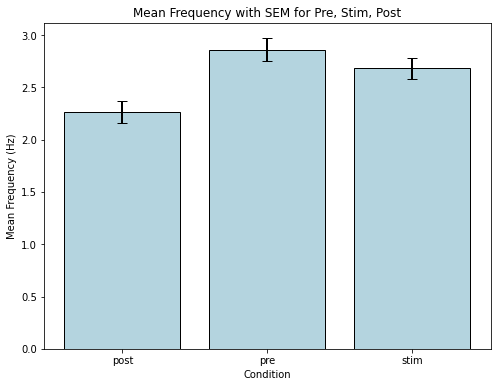

In [78]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming mean_df has already been created and contains 'Trial', 'Interval', and 'Mean Frequency'

# Calculate the mean, median, and SEM for each condition (pre, stim, post)
summary_stats = mean_df.groupby('Interval').agg(
    mean_frequency=('Mean Frequency', 'mean'),
    median_frequency=('Mean Frequency', 'median'),
    sem_frequency=('Mean Frequency', stats.sem)
).reset_index()

# Display summary statistics for each condition
print("Summary Statistics (Mean, Median, SEM) for Each Condition:")
print(summary_stats)

# Perform Friedman Test (Non-parametric alternative to repeated measures ANOVA)
# This is appropriate when the same trials (repeated measures) are used for pre, stim, post
pre_data = mean_df[mean_df['Interval'] == 'pre']['Mean Frequency']
stim_data = mean_df[mean_df['Interval'] == 'stim']['Mean Frequency']
post_data = mean_df[mean_df['Interval'] == 'post']['Mean Frequency']

# Combine the data for the statistical test
data_for_friedman = np.array([pre_data, stim_data, post_data]).T

# Perform the Friedman test
friedman_stat, friedman_p = stats.friedmanchisquare(pre_data, stim_data, post_data)

print(f"\nFriedman Test: Statistic = {friedman_stat}, p-value = {friedman_p}")

# Perform pairwise comparisons using the Wilcoxon signed-rank test (non-parametric)
pre_stim_stat, pre_stim_p = stats.wilcoxon(pre_data, stim_data)
stim_post_stat, stim_post_p = stats.wilcoxon(stim_data, post_data)
pre_post_stat, pre_post_p = stats.wilcoxon(pre_data, post_data)

print("\nPairwise Comparisons (Wilcoxon Signed-Rank Test):")
print(f"Pre vs. Stim: Statistic = {pre_stim_stat}, p-value = {pre_stim_p}")
print(f"Stim vs. Post: Statistic = {stim_post_stat}, p-value = {stim_post_p}")
print(f"Pre vs. Post: Statistic = {pre_post_stat}, p-value = {pre_post_p}")

# Optional: Create a summary plot (mean and SEM)
plt.figure(figsize=(8, 6))
sns.barplot(x='Interval', y='mean_frequency', data=summary_stats, ci=None, color='lightblue', edgecolor='black')

# Add error bars (SEM)
plt.errorbar(x=summary_stats['Interval'], y=summary_stats['mean_frequency'], 
             yerr=summary_stats['sem_frequency'], fmt='none', capsize=5, color='black', linewidth=2)

# Add labels and title
plt.title('Mean Frequency with SEM for Pre, Stim, Post')
plt.ylabel('Mean Frequency (Hz)')
plt.xlabel('Condition')

# Show the plot
plt.show()


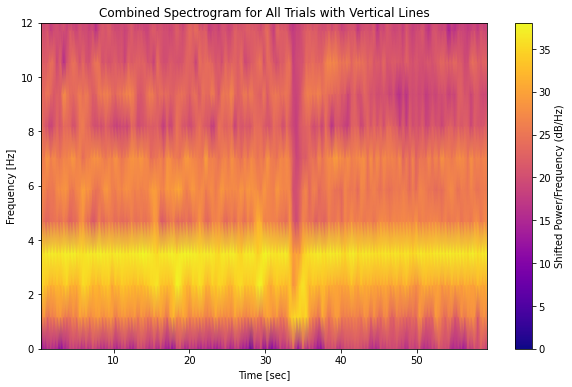

Spectrogram saved as E:\heart_beat\output\combined_spectrogram_with_lines.png


In [3]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Define the root directory where the pickle files are stored
root_dir = r'E:\heart_beat\output'

# Initialize variables to store combined spectrogram
combined_Sxx = None
common_frequencies = None
combined_times = None

# Loop through all files in the root directory
for filename in os.listdir(root_dir):
    if filename.endswith('.pkl'):
        # Construct the full file path
        file_path = os.path.join(root_dir, filename)
        
        # Load the pickle file
        with open(file_path, 'rb') as f:
            spectrogram_data = pickle.load(f)
        
        # Extract spectrogram data
        frequencies = spectrogram_data['frequencies']
        times = spectrogram_data['times']
        Sxx = spectrogram_data['Sxx']
        
        # Initialize combined Sxx if it's the first iteration
        if combined_Sxx is None:
            combined_Sxx = np.zeros_like(Sxx)
            combined_times = times
            common_frequencies = frequencies
        
        # Check if the spectrograms have the same dimensions
        if Sxx.shape == combined_Sxx.shape:
            combined_Sxx += Sxx  # Add intensity (power)
        else:
            print(f"Warning: Spectrogram shape mismatch for {filename}. Skipping this file.")

# Apply log scale and shift all values by a constant to make the color bar non-negative
dB_Sxx = 10 * np.log10(combined_Sxx + 1e-10)  # Convert to dB
dB_shift = np.abs(np.min(dB_Sxx))  # Find the minimum value in dB
dB_Sxx += dB_shift  # Shift all values up to make the minimum 0

# Plot the combined spectrogram
plt.figure(figsize=(10, 6))

# Choose between 'plasma' or 'gray' colormap
cmap_choice = 'plasma'  # Change to 'gray' for grayscale colormap

# Plot the shifted dB scale
plt.pcolormesh(combined_times, common_frequencies, dB_Sxx, shading='gouraud', cmap=cmap_choice)

# Add vertical lines at 30 and 33 seconds
#plt.axvline(x=30, color='black', linestyle='--', linewidth=2)  # Line at 30 seconds
#plt.axvline(x=33, color='black', linestyle='--', linewidth=2)  # Line at 33 seconds

# Add labels and title
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Combined Spectrogram for All Trials with Vertical Lines')
plt.ylim(0,12)
# Show color bar
plt.colorbar(label='Shifted Power/Frequency (dB/Hz)')

# Save the plot as an SVG file
output_svg = os.path.join(r'E:\heart_beat\output', 'combined_spectrogram_with_lines.png')
plt.savefig(output_svg, format='png')

# Show the plot
plt.show()

print(f"Spectrogram saved as {output_svg}")


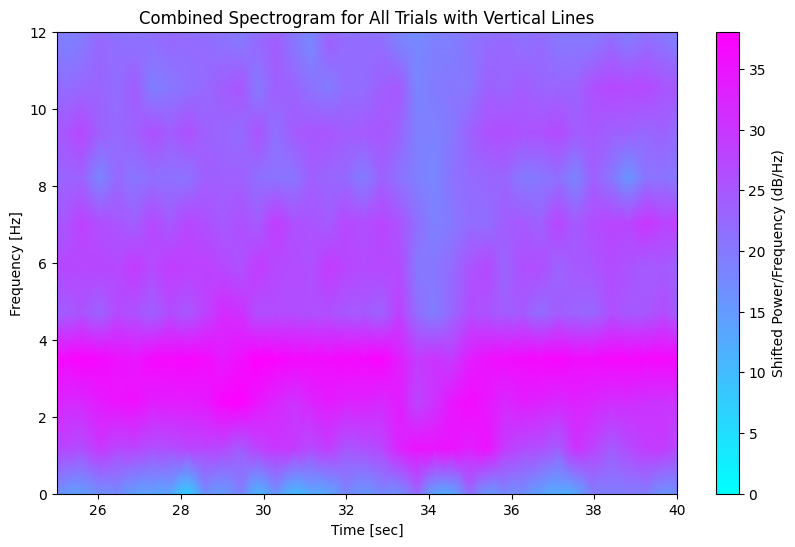

Spectrogram saved as D:\heart_beat\output\combined_spectrogram_with_lines_zoom.png


In [20]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Define the root directory where the pickle files are stored
root_dir = r'D:\heart_beat\output'

# Initialize variables to store combined spectrogram
combined_Sxx = None
common_frequencies = None
combined_times = None

# Loop through all files in the root directory
for filename in os.listdir(root_dir):
    if filename.endswith('.pkl'):
        # Construct the full file path
        file_path = os.path.join(root_dir, filename)
        
        # Load the pickle file
        with open(file_path, 'rb') as f:
            spectrogram_data = pickle.load(f)
        
        # Extract spectrogram data
        frequencies = spectrogram_data['frequencies']
        times = spectrogram_data['times']
        Sxx = spectrogram_data['Sxx']
        
        # Initialize combined Sxx if it's the first iteration
        if combined_Sxx is None:
            combined_Sxx = np.zeros_like(Sxx)
            combined_times = times
            common_frequencies = frequencies
        
        # Check if the spectrograms have the same dimensions
        if Sxx.shape == combined_Sxx.shape:
            combined_Sxx += Sxx  # Add intensity (power)
        else:
            print(f"Warning: Spectrogram shape mismatch for {filename}. Skipping this file.")

# Apply log scale and shift all values by a constant to make the color bar non-negative
dB_Sxx = 10 * np.log10(combined_Sxx + 1e-10)  # Convert to dB
dB_shift = np.abs(np.min(dB_Sxx))  # Find the minimum value in dB
dB_Sxx += dB_shift  # Shift all values up to make the minimum 0

# Plot the combined spectrogram
plt.figure(figsize=(10, 6))

# Choose between 'plasma' or 'gray' colormap
cmap_choice = 'plasma'  # Change to 'gray' for grayscale colormap

# Plot the shifted dB scale
plt.pcolormesh(combined_times, common_frequencies, dB_Sxx, shading='gouraud', cmap="cool")

# Add vertical lines at 30 and 33 seconds
#plt.axvline(x=30, color='black', linestyle='--', linewidth=2)  # Line at 30 seconds
#plt.axvline(x=33, color='black', linestyle='--', linewidth=2)  # Line at 33 seconds

# Add labels and title
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Combined Spectrogram for All Trials with Vertical Lines')
plt.ylim(0,12)
plt.xlim(25,40)
# Show color bar
plt.colorbar(label='Shifted Power/Frequency (dB/Hz)')

# Save the plot as an SVG file
output_svg = os.path.join(r'D:\heart_beat\output', 'combined_spectrogram_with_lines_zoom.png')
plt.savefig(output_svg, format='png')

# Show the plot
plt.show()

print(f"Spectrogram saved as {output_svg}")
